## Problem Understanding

A bank is interested in predicting which customers are likely to default on loans in advance.It can adjust customer's credit worthiness criteria accordingly and avoid giving out bad loans. It has collected data like credit utilization,age,past delinquency,debt ratio,income etc related to the customer. 

## Data Understanding

![](variable_description.PNG)

## Workflow
+ Clean and Wrangle data to get it in desired format
+ Visualize and understand which factors are more important in predicting delinquency
+ Build models
+ Evaluate models
+ Predict on test set.  
Here I'll be using xgboost,catboost and neural networks to predict delinquency since these are the top performing ML algorithms.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [26]:
# Dropping the first column since it was a repitition of the index column
df_train=pd.read_csv('cs-training.csv').iloc[:,1:]
df_test=pd.read_csv('cs-test.csv').iloc[:,1:]

df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Data Cleaning

In [15]:
print(f'Training set has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'Test set has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

Training set has 150000 rows and 11 columns
Test set has 101503 rows and 11 columns


In [44]:
# Identifying columns with missing values

np.round(100*df_train.isnull().sum()/len(df_train),2)

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

It appears monthly income and number od dependents have around 20% and 3% missing values respectively. Imputation strategies need to be decided after looking at the distribution of these variables

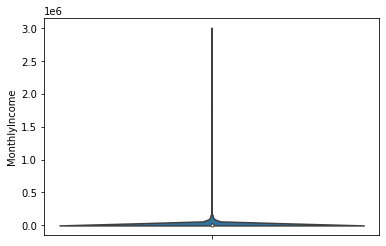

In [28]:
# Visualizing the monthly income column

sns.violinplot(data=df_train,y='MonthlyIncome')

As seen above, monthly income has a very long tail and missing values will be imputed with the median value

In [30]:
# Imputing missing values in the monthly income column with the median income
income_med=df_train['MonthlyIncome'].median()
df_train['MonthlyIncome']=df_train['MonthlyIncome'].fillna(income_med)
df_test['MonthlyIncome']=df_test['MonthlyIncome'].fillna(income_med)

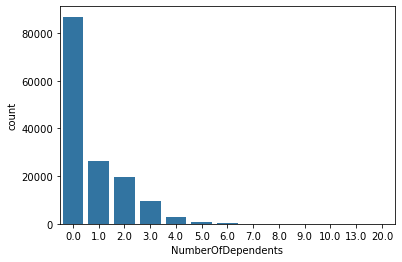

In [32]:
# Visualizing number of dependents 
base_color=sns.color_palette()[0]
sns.countplot(data=df_train,x='NumberOfDependents',color=base_color);

Vast majority of the people have no dependents and hence missing values will be imputed with 0

In [33]:
df_train['NumberOfDependents']=df_train['NumberOfDependents'].fillna(0)
df_test['NumberOfDependents']=df_test['NumberOfDependents'].fillna(0)

## visualizing and understanding data

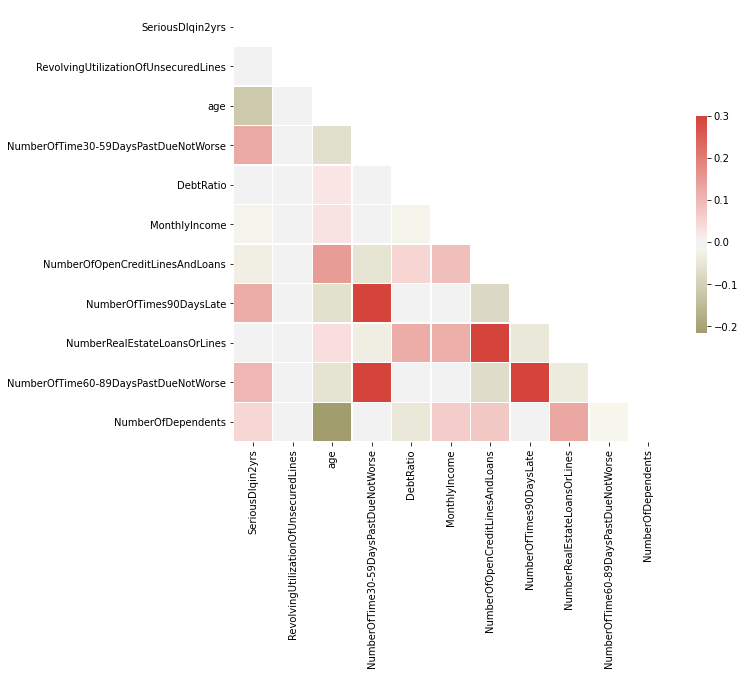

In [41]:
# Calculating the correlation matrix between different variables
corr_matrix=df_train.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(800, 14, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

+ From the above heatmap it is evident that NumberofDependants, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse and age are the most important factors in predicting possibility of delinquency.  
  
  
+ Past delinquency records,number of dependents and  a person's age are determining factors to predict delinquency

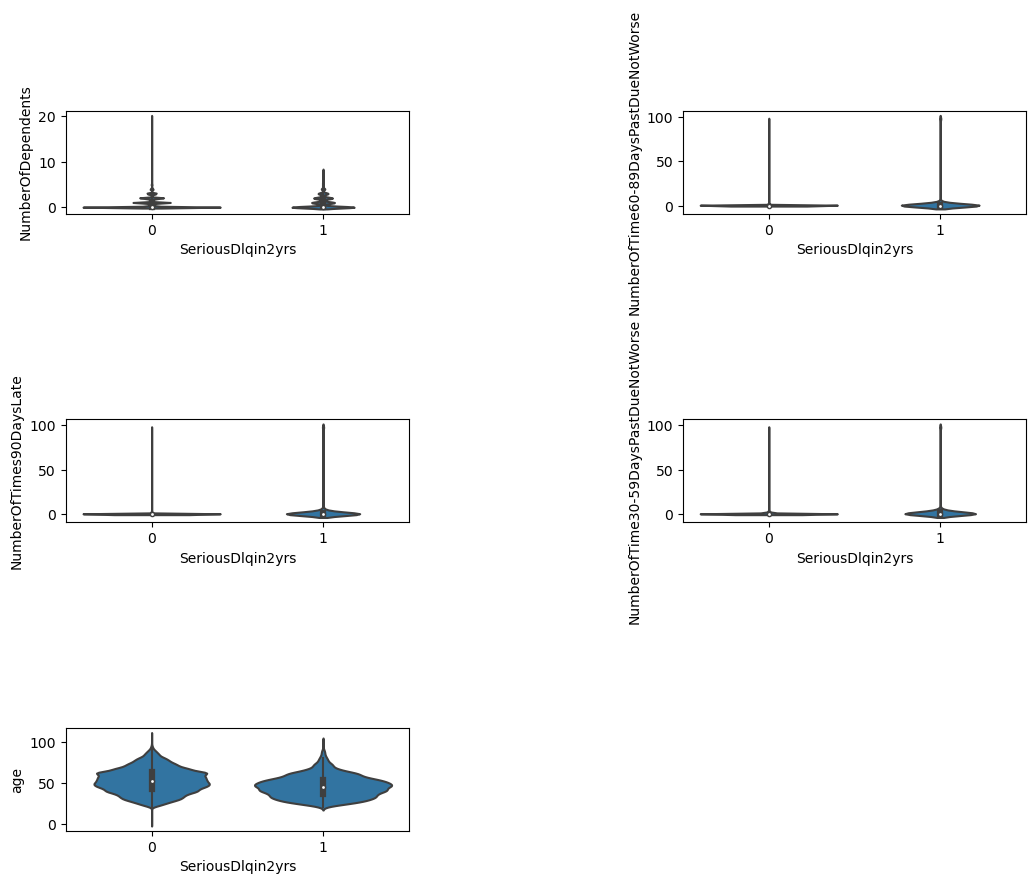

In [92]:
df_train['SeriousDlqin2yrs']=df_train['SeriousDlqin2yrs'].astype('category')
base_color=sns.color_palette()[0]

cols_to_plot=['NumberOfDependents','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate',
             'NumberOfTime30-59DaysPastDueNotWorse','age']


i=1
for col in cols_to_plot:
    fig=plt.subplot(3,2,i)
    fig.xaxis.set_ticklabels([])
    sns.violinplot(data=df_train,y=col,x='SeriousDlqin2yrs',color=base_color)
    i+=1
    
plt.subplots_adjust(right=1.5,top=1.5,left=0,bottom=0,wspace=0.8,hspace=2)


+ It appears that people with more than 10 dependents are less likely to default. 
+ people who default tend to delay their payments
+ Although the difference is small, younger people tend to default more

In [93]:
#resetting matplotlib plotting parameters
mpl.rcParams.update(mpl.rcParamsDefault)